# HW4Q2

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time
%matplotlib inline

# Convert classes to indicator vectors
def one_hot(values,n_values=10):
    n_v = np.maximum(n_values,np.max(values) + 1)
    oh=np.eye(n_v)[values]
    return oh
print(tf.__version__)

1.11.0


In [2]:
def get_cifar():
    tr=np.float32(np.load('/project/cmsc25025/mnist/CIFAR_10.npy'))
    tr_lb=np.int32(np.load('/project/cmsc25025/mnist/CIFAR_labels.npy'))
    tr=tr.reshape((-1,np.prod(np.array(tr.shape)[1:4])))
    train_data=tr[0:10000]/255.
    train_labels=one_hot(tr_lb[0:10000])
    val_data=tr[10000:]/255.
    val_labels=one_hot(tr_lb[10000:])
    test_data=np.float32(np.load('/project/cmsc25025/mnist/CIFAR_10_test.npy'))
    test_data=test_data.reshape((-1,np.prod(np.array(test_data.shape)[1:4])))
    test_data=test_data/255.
    test_labels=one_hot(np.int32(np.load('/project/cmsc25025/mnist/CIFAR_labels_test.npy')))
    return (train_data, train_labels), (val_data, val_labels), (test_data, test_labels)

In [3]:
def conv_relu_layer(input,filter_size=[3,3],num_features=[1]):
    # Get number of input features from input and add to shape of new layer
    shape=filter_size+[input.get_shape().as_list()[-1],num_features]
    W = tf.get_variable('W',shape=shape) # Default initialization is Glorot (the one explained in the slides)
    b = tf.get_variable('b',shape=[num_features],initializer=tf.zeros_initializer) 
    conv = tf.nn.conv2d(input, W, strides=[1, 1, 1, 1], padding='SAME')
    relu = tf.nn.relu(conv + b)
    return(relu)

In [4]:
def fully_connected_layer(input,num_features):
    # Make sure input is flattened.
    flat_dim=np.int32(np.array(input.get_shape().as_list())[1:].prod())
    input_flattened = tf.reshape(input, shape=[-1,flat_dim])
    shape=[flat_dim,num_features]
    W_fc = tf.get_variable('W',shape=shape) 
    b_fc = tf.get_variable('b',shape=[num_features],initializer=tf.zeros_initializer)
    fc = tf.matmul(input_flattened, W_fc) + b_fc
    return(fc)

In [5]:
def create_network(f1, f2, f3, f4, deeper = False):
    pool_ksize=[1,2,2,1]
    pool_strides=[1,2,2,1]
    # The network:
    with tf.variable_scope("conv1"):
            # Variables created here will be named "conv1/weights", "conv1/biases".
            relu1 = conv_relu_layer(x_image, filter_size=[5, 5],num_features=f1)
            pool1 = tf.nn.max_pool(relu1, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    with tf.variable_scope("conv2"):
            # Variables created here will be named "conv1/weights", "conv1/biases".
            relu2 = conv_relu_layer(pool1, filter_size=[5, 5],num_features=f2)
            pool2 = tf.nn.max_pool(relu2, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    if deeper:
        with tf.variable_scope("conv3"):
            # Variables created here will be named "conv1/weights", "conv1/biases".
            relu3 = conv_relu_layer(pool2, filter_size=[5, 5],num_features=f2*2)
            pool3 = tf.nn.max_pool(relu3, ksize=pool_ksize, strides=pool_strides, padding='SAME')
        with tf.variable_scope("conv4"):
            # Variables created here will be named "conv1/weights", "conv1/biases".
            relu4 = conv_relu_layer(pool3, filter_size=[5, 5],num_features=f2*4)
            pool4 = tf.nn.max_pool(relu4, ksize=pool_ksize, strides=pool_strides, padding='SAME')
            
    with tf.variable_scope('dropout2'):
            drop2 = tf.nn.dropout(pool2,keep_prob)
    with tf.variable_scope("fc1"):
            fc1 = fully_connected_layer(drop2, num_features=f3)
            fc1r= tf.nn.relu(fc1)
   
    with tf.variable_scope("fc2"):
            fc2 = fully_connected_layer(fc1r, num_features=f4)

    # Names (OUT,LOSS, ACC) below added to make it easier to use this tensor when restoring model
    fc2 = tf.identity(fc2, name="OUT")
    # The loss computation
    with tf.variable_scope('cross_entropy_loss'):
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=fc2),name="LOSS")

    # Accuracy computation
    with tf.variable_scope('helpers'):
        correct_prediction = tf.equal(tf.argmax(fc2, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32),name="ACC")
    # We return the final functions (they contain all the information about the graph of the network)
    return cross_entropy, accuracy

In [6]:
# Run the iterations of one epoch
def run_epoch(sess,OPS,data,batch_size, type="train", num=None):
        t1=time.time()
        n=data[0].shape[0]
        if (num is not None):
            n=np.minimum(n,num)
        ii=np.array(np.arange(0,n,1))
    
        # Randomly shuffle the training data
        if (type=="train"):
            np.random.shuffle(ii)
        tr=data[0][ii]
        y=data[1][ii]
        loo=0.
        acc=0.
        nb=0.
        # Run disjoint batches on shuffled data
        for j in np.arange(0,len(y),batch_size):
            #if (np.mod(j,5000)==0):
                #print('Batch',j/batch_size)
            batch=(tr[j:j+batch_size],y[j:j+batch_size])
            if (type=="train"):
                lo,ac,_=sess.run([OPS['cross_entropy'],OPS['accuracy'],OPS['train_step']],feed_dict={x: batch[0], y_: batch[1], lr_: step_size,keep_prob_:keep_prob}) 
            else:
                lo,ac = sess.run([OPS['cross_entropy'],OPS['accuracy']],feed_dict={x: batch[0], y_: batch[1], lr_: step_size,keep_prob_:1.})
            loo+=lo
            acc+=ac
            nb+=1
        loo=loo/nb
        acc=acc/nb
        #print('Epoch time',time.time()-t1)
        return loo, acc

In [7]:
def getActivation(layer, filters):
    n_columns = 8
    n_rows = 4
    plt.figure(figsize=(2*n_columns, 2*n_rows))
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow((layer[:,:,:,i].eval()*255).astype(np.uint8), cmap="gnuplot2")
        plt.axis('off')

In [14]:
def plot_error(num_epochs, train_err, valid_err):
    fig = plt.figure(figsize=(9,6))
    plt.plot(list(range(num_epochs)), train_err, label="Training set")
    plt.plot(list(range(num_epochs)), valid_err, linestyle='dashed', label="Validation set")
    plt.legend()
    plt.xlabel("Number of Epoch", fontsize=10)
    plt.ylabel("Error Rate", fontsize=10)
    plt.title("Error Rate vs Epoch Number", fontsize=15)
    plt.show()

#### display images

In [65]:
train,val,test= get_cifar()

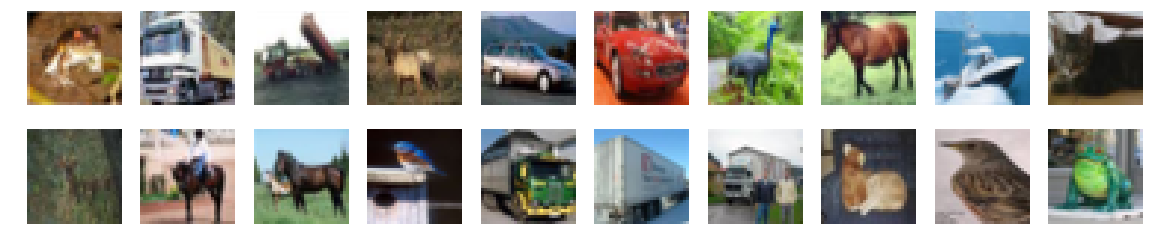

In [8]:
nrows, ncols = 2, 10
plt.figure(figsize=(ncols*2, nrows*2))
for i in range(nrows*ncols):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(train[0][i].reshape((32,32,3)), cmap='gnuplot2')
    plt.axis('off')      
plt.axis('off')
plt.show()

In [9]:
batch_size=500
step_size=.001
num_epochs = 20
num_train=10000
minimizer="Adam"
model_name="model"
keep_prob=.5
dim=32
nchannels=3

tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape=[None, dim*dim*nchannels],name="x")
x_image = tf.reshape(x, [-1, dim, dim, nchannels])

y_ = tf.placeholder(tf.float32, shape=[None,10],name="y")
lr_ = tf.placeholder(tf.float32, shape=[],name="learning_rate")
keep_prob_=tf.placeholder(tf.float32, shape=[],name="keep_prob")

In [10]:
def train_model(num_epochs, f1, f2, f3, f4, layer = None):
    
    train_err = np.zeros(num_epochs)
    valid_err = np.zeros(num_epochs)
    
    with tf.Session() as sess:
        # Create the network architecture with the above placeholdes as the inputs.
        cross_entropy, accuracy=create_network(f1, f2, f3, f4)

        # Define the miminization method
        if (minimizer=="Adam"):
            train_step=tf.train.AdamOptimizer(learning_rate=lr_).minimize(cross_entropy)
        elif (minimizer=="SGD"):
            train_step = tf.train.GradientDescentOptimizer(learning_rate=lr_).minimize(cross_entropy)
        OPS={}
        OPS['cross_entropy']=cross_entropy; OPS['accuracy']=accuracy; OPS['train_step']=train_step
        # Initialize variables
        sess.run(tf.global_variables_initializer())
        # Show trainable variables
        for v in tf.trainable_variables():
            print(v.name,v.get_shape().as_list(),np.std(v.eval()))
    
        # Run epochs
        for i in range(num_epochs):  # number of epochs
            lo,ac=run_epoch(sess,OPS,train,batch_size,type="train",num=num_train)  
            train_err[i] = 1- ac
            # print('Epoch',i,'Train loss, accuracy',lo,ac)
            vlo,vac = run_epoch(sess,OPS,val,batch_size,type="test")
            valid_err[i] = 1- vac
            # print('Epoch',i,'Validation loss, accuracy',vlo,vac)
         # Test set accuracy
        telo,teac = run_epoch(sess,OPS,test,batch_size,type="test")
        print('test accuracy',telo,teac)
        
        if layer:
            Layer = tf.trainable_variables()[layer-1]
            getActivation(Layer, 32)
    
        # Save model
        tf.add_to_collection("optimizer", train_step)
        saver = tf.train.Saver()
        save_path = saver.save(sess, "tmp/"+model_name)
        print("Model saved in path: %s" % save_path)
        return train_err, valid_err

conv1/W:0 [5, 5, 3, 32] 0.0486138
conv1/b:0 [32] 0.0
conv2/W:0 [5, 5, 32, 64] 0.028831
conv2/b:0 [64] 0.0
fc1/W:0 [4096, 256] 0.0214355
fc1/b:0 [256] 0.0
fc2/W:0 [256, 10] 0.0870342
fc2/b:0 [10] 0.0
test accuracy 1.19048274755 0.593400001526
Model saved in path: tmp/model


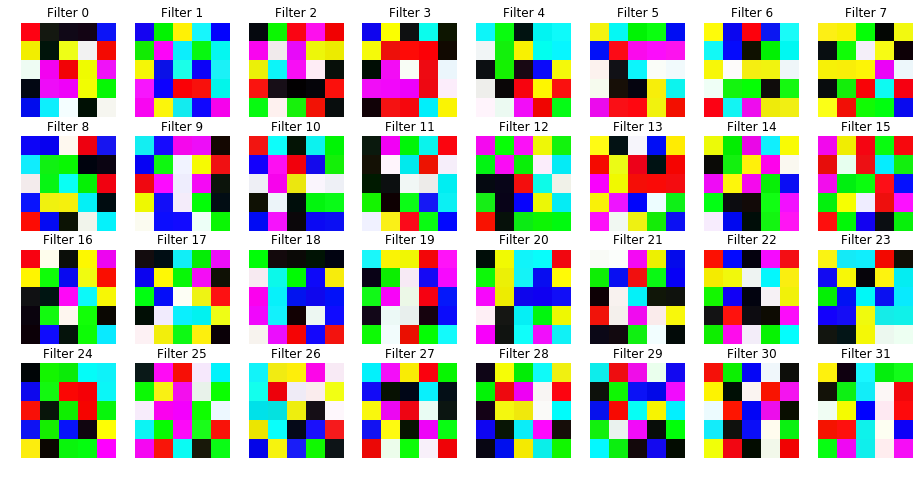

In [41]:
train_err, valid_err = train_model(20, 32, 64, 256, 10, layer = 1)

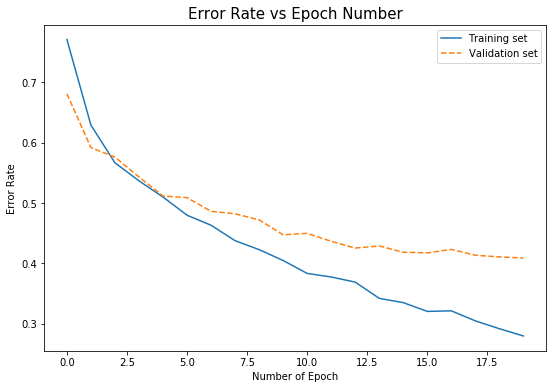

In [42]:
ig = plt.figure(figsize=(9,6))
plt.plot(list(range(num_epochs)), train_err, label="Training set")
plt.plot(list(range(num_epochs)), valid_err, linestyle='dashed', label="Validation set")
plt.legend()
plt.xlabel("Number of Epoch", fontsize=10)
plt.ylabel("Error Rate", fontsize=10)
plt.title("Error Rate vs Epoch Number", fontsize=15)
plt.show()

#### experiment with deeper network 

conv1/W:0 [5, 5, 3, 32] 0.0476195
conv1/b:0 [32] 0.0
conv2/W:0 [5, 5, 32, 64] 0.0288531
conv2/b:0 [64] 0.0
fc1/W:0 [4096, 256] 0.0214293
fc1/b:0 [256] 0.0
fc2/W:0 [256, 10] 0.0881135
fc2/b:0 [10] 0.0
test accuracy 1.2314103961 0.581399998069
Model saved in path: tmp/model


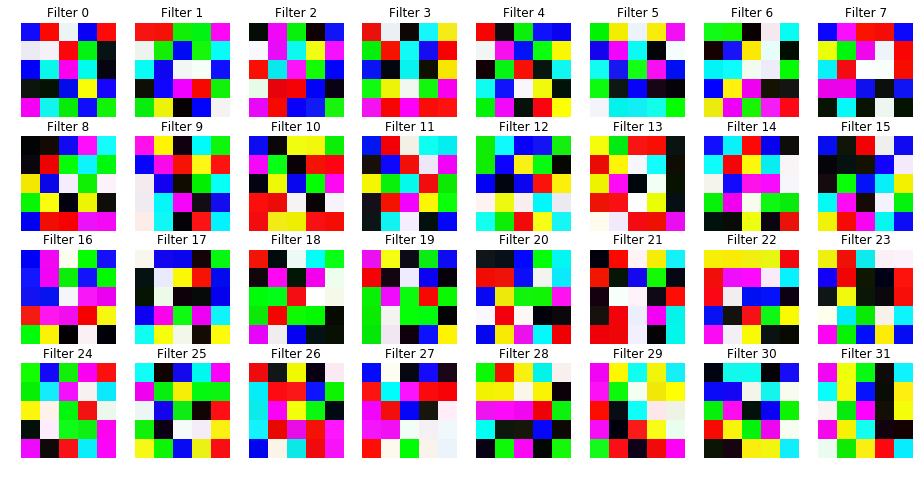

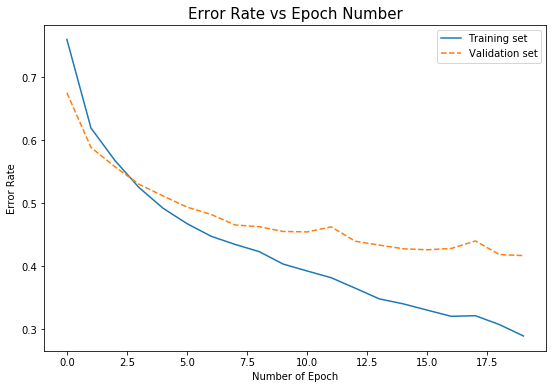

In [60]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape=[None, dim*dim*nchannels],name="x")
x_image = tf.reshape(x, [-1, dim, dim, nchannels])
y_ = tf.placeholder(tf.float32, shape=[None,10],name="y")
lr_ = tf.placeholder(tf.float32, shape=[],name="learning_rate")
keep_prob_=tf.placeholder(tf.float32, shape=[],name="keep_prob")
train_err_d, valid_err_d = train_model(20, 32, 64, 256, 10, True)
plot_error(num_epochs, train_err_d, valid_err_d)

#### variability

In [58]:
from skimage import color
def transform(test_dat):
    nrows, ncols = 2, 10
    plt.figure(figsize=(ncols*2, nrows*2))
    for i in range(ncols):
        # plot the original data
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(test_dat[0][i].reshape((32,32,3)), cmap='gnuplot2')
        plt.axis('off') 
        plt.title('Original Data')
        
        # plot the transformed data
        plt.subplot(nrows, ncols, i+1+10)
        img_hsv = color.rgb2hsv(test_dat[0][i].reshape((32,32,3)))
        # change saturation
        scale = np.random.randint(75, 125+1, 1)/100
        img_hsv[:,:,1] = img_hsv[:,:,1]*scale
        # transform back to rgb
        img_rgb = color.hsv2rgb(img_hsv.reshape((32,32,3)))
        plt.imshow((img_rgb*255).astype(np.uint8), cmap='gnuplot2')
        plt.axis('off') 
        plt.title('Tranformed Data')
    plt.axis('off')
    plt.show()

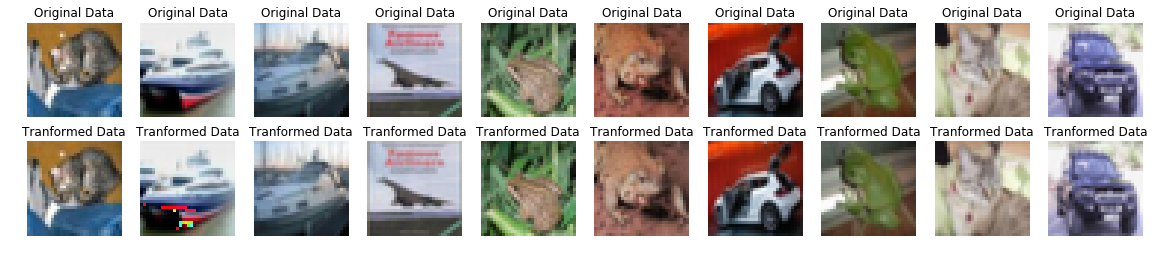

In [59]:
# display the original data and tranformed data 
transform(test)

In [80]:
# tranform all data
def tsf_data(test):
    tsf = np.zeros((test[0].shape[0], 32, 32, 3))
    for i in range(test[0].shape[0]):
        img_hsv = color.rgb2hsv(test[0][i].reshape((32,32,3)))
        # change saturation
        scale = np.random.randint(75, 125+1, 1)/100
        img_hsv[:,:,1] = img_hsv[:,:,1]*scale
        # transform back to rgb
        tsf[i,:,:,:] = color.hsv2rgb(img_hsv.reshape((32,32,3)))
    return tsf
tsf = tsf_data(test)
tsf = tsf.reshape((test[0].shape[0], 3072))
test = (tsf, test[1])

conv1/W:0 [5, 5, 3, 32] 0.0478122
conv1/b:0 [32] 0.0
conv2/W:0 [5, 5, 32, 64] 0.0289879
conv2/b:0 [64] 0.0
fc1/W:0 [4096, 256] 0.0214189
fc1/b:0 [256] 0.0
fc2/W:0 [256, 10] 0.0860009
fc2/b:0 [10] 0.0
test accuracy 1.22318490744 0.584200000763
Model saved in path: tmp/model


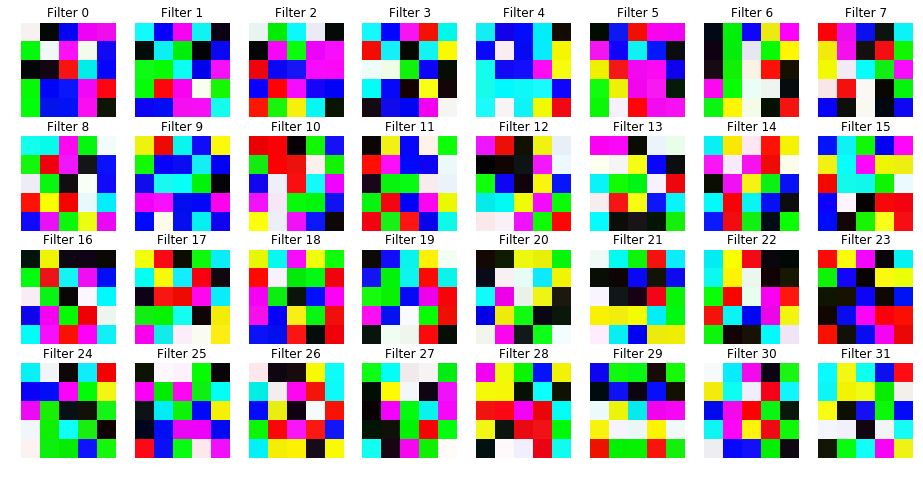

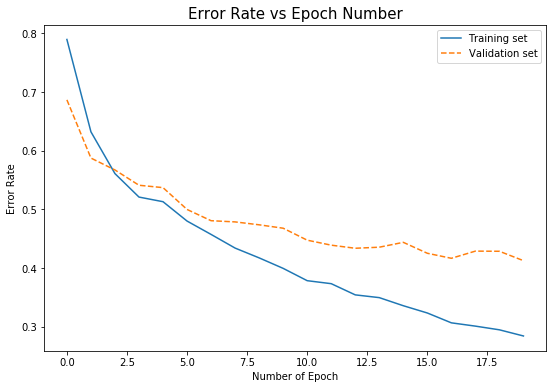

In [81]:
# train model on the transformed data
tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape=[None, dim*dim*nchannels],name="x")
x_image = tf.reshape(x, [-1, dim, dim, nchannels])
y_ = tf.placeholder(tf.float32, shape=[None,10],name="y")
lr_ = tf.placeholder(tf.float32, shape=[],name="learning_rate")
keep_prob_=tf.placeholder(tf.float32, shape=[],name="keep_prob")
train_err_t, valid_err_t = train_model(20, 32, 64, 256, 10, True)
plot_error(num_epochs, train_err_t, valid_err_t)

conv1/W:0 [5, 5, 3, 32] 0.0476495
conv1/b:0 [32] 0.0
conv2/W:0 [5, 5, 32, 64] 0.0288399
conv2/b:0 [64] 0.0
fc1/W:0 [4096, 256] 0.0214489
fc1/b:0 [256] 0.0
fc2/W:0 [256, 10] 0.0860421
fc2/b:0 [10] 0.0
test accuracy 1.20796346068 0.581400001049
Model saved in path: tmp/model


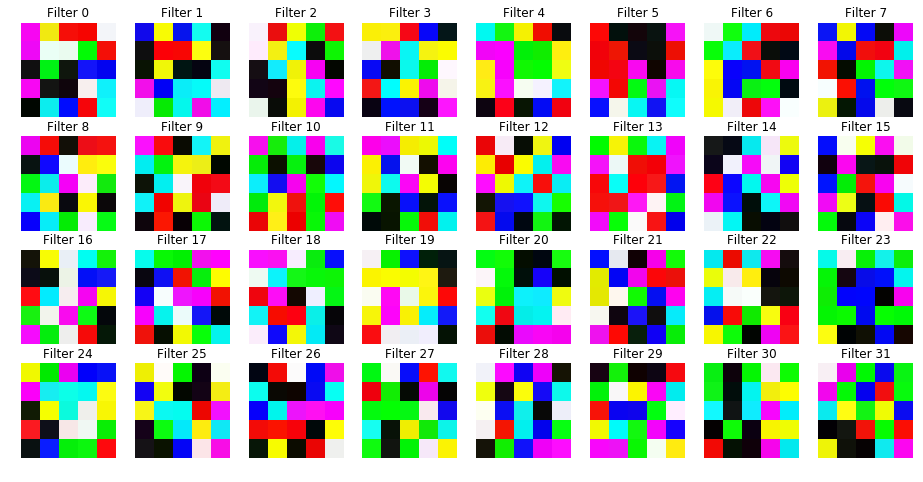

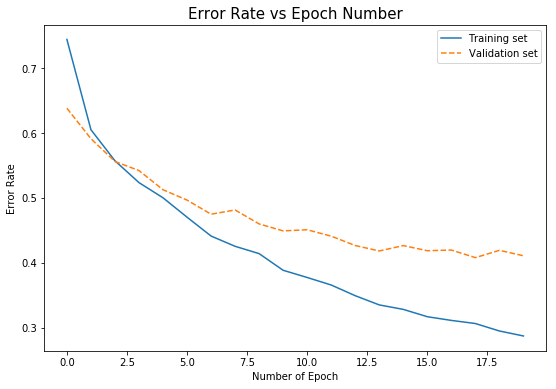

In [79]:
# train model on the transformed data
tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape=[None, dim*dim*nchannels],name="x")
x_image = tf.reshape(x, [-1, dim, dim, nchannels])
y_ = tf.placeholder(tf.float32, shape=[None,10],name="y")
lr_ = tf.placeholder(tf.float32, shape=[],name="learning_rate")
keep_prob_=tf.placeholder(tf.float32, shape=[],name="keep_prob")
train_err_t, valid_err_t = train_model(20, 32, 64, 256, 10, True)
plot_error(num_epochs, train_err_t, valid_err_t)